In [38]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import math

In [39]:
def read_image(path):
    original_image = Image.open(path)
    resized_image = original_image.resize((256, 256))
    im = np.array(resized_image.convert('L'))
    im_uint8 = ((im - np.min(im)) * (1/(np.max(im) - np.min(im)) * 255)).astype('uint8')
    return im_uint8

## Convolution 

### With a padding of 2 and stride 1 to gain maximum information from the filtred image.

In [40]:
def convolution(f, I):
    filter_ht, filter_wdt = f.shape
    # padding = filter_ht - 1
    image_ht, image_wdt = I.shape

    pad_ht = filter_ht // 2
    pad_wdt = filter_wdt // 2
    pad_img = np.pad(I, ((pad_ht, pad_ht), (pad_wdt, pad_wdt)), mode = 'constant')

    im_conv = np.zeros_like(I, dtype = float)

    for i in range(image_ht):
        for j in range(image_wdt):
            roi = pad_img[i:i+filter_ht, j:j+filter_wdt]
            im_conv[i, j] = np.sum(roi * f)
    return im_conv        

In [41]:
def gaussian_filter(sigma, filter_size):
    # Ensure filter size is odd
    filter_size = filter_size + 1 if filter_size % 2 == 0 else filter_size

    # Calculate range of values
    x = np.arange(-filter_size // 2, filter_size // 2 + 1)

    # Calculate Gaussian kernel
    kernel = np.exp(-0.5 * (x / sigma) ** 2) / (sigma * math.sqrt(2 * math.pi))
    kernel /= np.sum(kernel)

    return kernel

In [42]:
def detect_zero_crossings(image,delta):
        res_img = np.zeros_like(image)
        ht, width = image.shape
        
        for i in range(1, ht - 1):
            for j in range(1, width - 1):
                mid_pixel = image[i, j]
                if mid_pixel > 0:  # If the center pixel is positive
                    neighbor = [image[i-1, j-1], image[i-1, j], image[i-1, j+1], image[i, j-1], image[i, j+1], image[i+1, j-1], image[i+1, j], image[i+1, j+1]]
                    for x in neighbor:
                        if x >= 0:
                            continue
                        if image[i, j] - x > delta:
                            res_img[i, j] = 255
                            break  
        
        return res_img


In [43]:
def otsu_threshold(im_in):
    image_data = im_in.flatten()
    bins = np.arange(0,256,1)

    hist = {bin: 0 for bin in bins}
    
    for i in image_data:
        for bin in bins:
            if i <= bin:
                hist[bin] +=1
                break

    hist_arr = np.array(list(hist.values()))
    bins_arr = np.array(list(hist.keys()))

    pdf = hist_arr / sum(hist_arr)

    cdf = [sum(pdf[:i+1]) for i in range(len(pdf))]

    cum_int = np.cumsum(np.arange(256) * pdf)
    mu = {}

    total_mean = cum_int[-1]
    max_var, best_thresh = 0, 0
    for thresh in range(1,256):
        fore = cdf[thresh]
        back = 1 - fore

        if fore == 0 or back == 0:
            continue
        mean_fore = cum_int[thresh] / fore
        mean_back = (total_mean - cum_int[thresh]) / back

        mu_fb = fore * back * (mean_back - mean_fore)**2
        mu[thresh] = mu_fb
        if mu_fb > max_var:
            max_var = mu_fb
            best_thresh = thresh

    thresh_image = np.zeros_like(im_in)
    thresh_image[im_in > best_thresh] = 255

    return thresh_image, best_thresh, mu




## Qn 1

### Cameraman

In [44]:
camera = read_image(r"C:\Users\rhuth\Desktop\SEMS\Sem - 2\CS - GY6643 - Computer Vision\Proj\Proj - 2\cameraman.png")

(-0.5, 255.5, 255.5, -0.5)

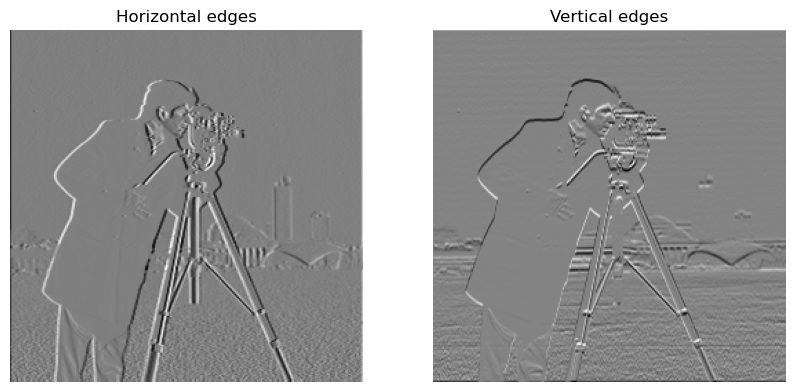

In [45]:
hor_filter = np.array([-1, 0, 1])
ver_filter = np.array([1, 0, -1])

res_hor = convolution(hor_filter.reshape(1, -1), camera)
res_ver = convolution(ver_filter.reshape(-1, 1), camera)

fig = plt.figure(figsize = (10,7))
fig.add_subplot(1,2,1)
plt.imshow(res_hor, cmap='binary')
plt.title("Horizontal edges")
plt.axis("off")

fig.add_subplot(1,2,2)
plt.imshow(res_ver, cmap='binary')
plt.title("Vertical edges")
plt.axis("off")



In [46]:
cv2.imwrite('Camera_hor_edges_1D.jpg', res_hor)
cv2.imwrite('Camera_ver_edges_1D.jpg', res_ver)

True

In [47]:
dx_filter = np.array([-1, 0, 1]).reshape(1,-1)
dy_filter = dx_filter.T
# print(dy_filter)

True

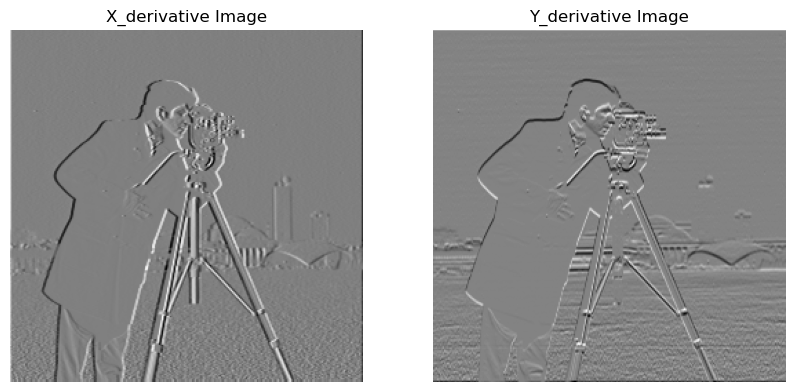

In [48]:
dx_der_img = convolution(dx_filter, camera)
dy_der_img = convolution(dy_filter, camera)

fig = plt.figure(figsize=(10,7))
fig.add_subplot(1,2,1)
plt.imshow(dx_der_img, cmap='gray')
plt.axis("off")
plt.title("X_derivative Image")
cv2.imwrite('Camera_X_Derivative_image.jpg', dx_der_img)

fig.add_subplot(1,2,2)
plt.imshow(dy_der_img, cmap='gray')
plt.axis("off")
plt.title("Y_derivative Image")
cv2.imwrite('Camera_Y_Derivative_image.jpg', dy_der_img)


True

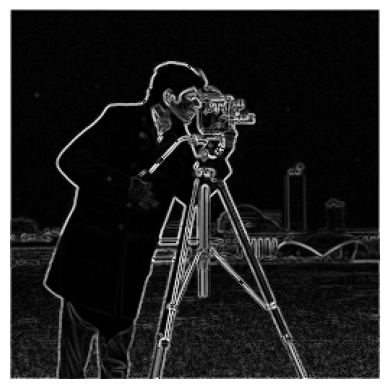

In [49]:
grad_magnitude = (np.sqrt(dx_der_img**2 + dy_der_img**2)).astype(np.uint8)
plt.imshow(grad_magnitude, cmap = 'gray')
plt.axis("off")
cv2.imwrite('Gradient_magnitude_Camera.jpg', grad_magnitude)

In [50]:
threshold, otsu_img = cv2.threshold(grad_magnitude, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

(-0.5, 255.5, 255.5, -0.5)

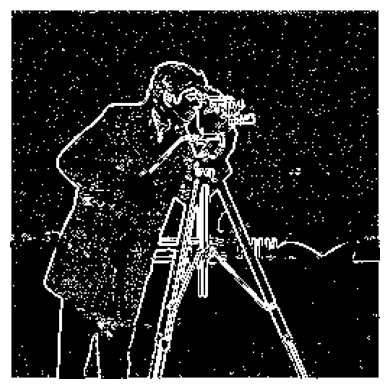

In [51]:
bin_edge_img = (grad_magnitude > otsu_img).astype(float)
plt.imshow(bin_edge_img, cmap = 'binary')
plt.axis("off")

Text(0.5, 1.0, 'Gaussian Filtered')

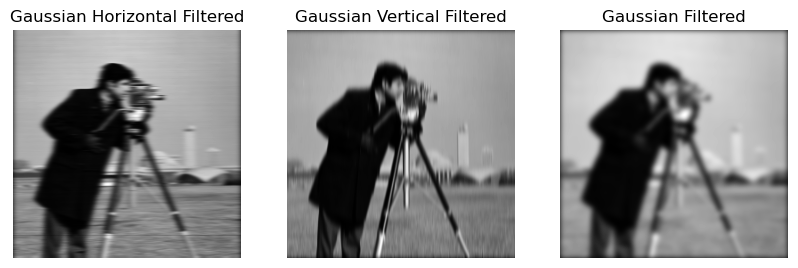

In [52]:
laplacian_fil = np.array([[0, -1, 0],
                          [-1, 4, -1],
                          [0, -1, 0]])

sigma = 3.0
filter_size = int(6 * sigma + 1)

Gx = gaussian_filter(sigma, filter_size)
Gy = Gx.reshape(-1, 1)

filt_hor_gau = convolution(Gx[np.newaxis, :], camera)
filt_ver_gau = convolution(Gy, camera)
filtered_img = convolution(Gx[np.newaxis, :], filt_ver_gau)

fig = plt.figure(figsize= (10,7))
fig.add_subplot(1,3,1)
plt.imshow(filt_hor_gau, cmap = 'gray')
plt.axis("off")
plt.title("Gaussian Horizontal Filtered")

fig.add_subplot(1,3,2)
plt.imshow(filt_ver_gau, cmap = 'gray')
plt.axis("off")
plt.title("Gaussian Vertical Filtered")

fig.add_subplot(1,3,3)
plt.imshow(filtered_img, cmap = 'gray')
plt.axis("off")
plt.title("Gaussian Filtered")


(-0.5, 255.5, 255.5, -0.5)

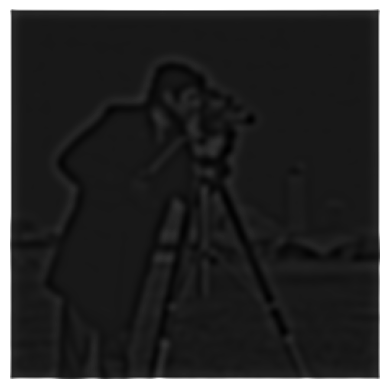

In [53]:
lap_img = convolution(laplacian_fil, filtered_img)
plt.imshow(lap_img, cmap='gray')
plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

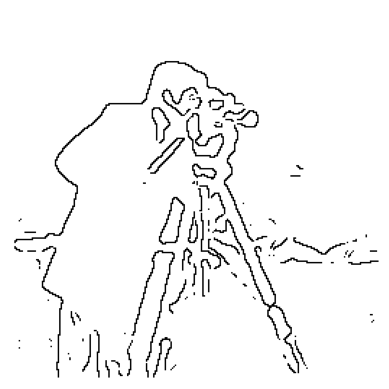

In [58]:
res_img = detect_zero_crossings(lap_img, 1)
plt.imshow(res_img, cmap= 'binary')
plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

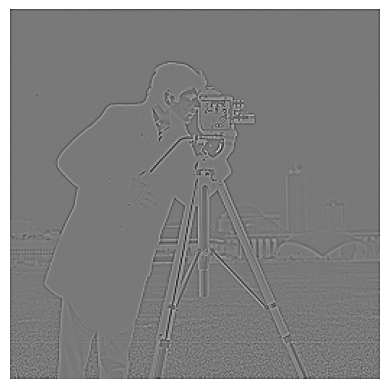

In [59]:
res_img_2D_fil = convolution(laplacian_fil, camera)
plt.imshow(res_img_2D_fil, cmap = 'binary')
plt.axis("off")

### Zebra

In [60]:
zebra = read_image(r"C:\Users\rhuth\Desktop\SEMS\Sem - 2\CS - GY6643 - Computer Vision\Proj\Proj - 2\zebra.png")

(-0.5, 255.5, 255.5, -0.5)

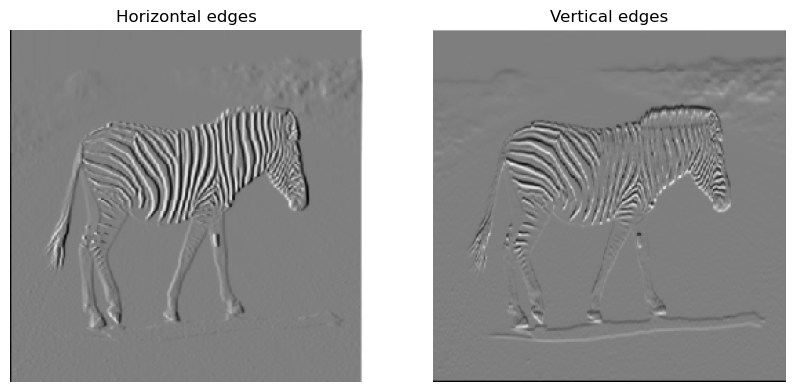

In [61]:
hor_filter = np.array([-1, 0, 1])
ver_filter = np.array([1, 0, -1])

res_hor = convolution(hor_filter.reshape(1, -1), zebra)
res_ver = convolution(ver_filter.reshape(-1, 1), zebra)

fig = plt.figure(figsize = (10,7))
fig.add_subplot(1,2,1)
plt.imshow(res_hor, cmap='binary')
plt.title("Horizontal edges")
plt.axis("off")

fig.add_subplot(1,2,2)
plt.imshow(res_ver, cmap='binary')
plt.title("Vertical edges")
plt.axis("off")



Text(0.5, 1.0, 'Y_derivative_Zebra_Image')

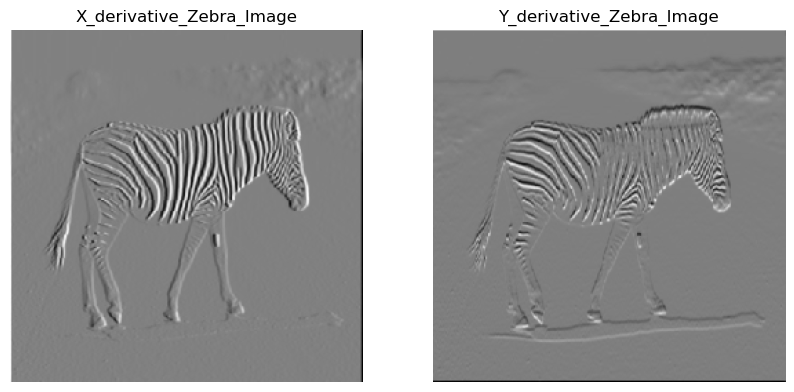

In [62]:
dx_der_zebra_img = convolution(dx_filter, zebra)
dy_der_zebra_img = convolution(dy_filter, zebra)

fig = plt.figure(figsize=(10,7))
fig.add_subplot(1,2,1)
plt.imshow(dx_der_zebra_img, cmap='gray')
plt.axis("off")
plt.title("X_derivative_Zebra_Image")
# cv2.imwrite('Camera_X_Derivative_image.jpg', dx_der_img)

fig.add_subplot(1,2,2)
plt.imshow(dy_der_zebra_img, cmap='gray')
plt.axis("off")
plt.title("Y_derivative_Zebra_Image")
# cv2.imwrite('Camera_Y_Derivative_image.jpg', dy_der_img)


(-0.5, 255.5, 255.5, -0.5)

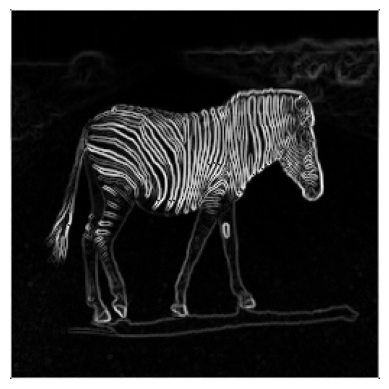

In [63]:
grad_magnitude_zebra = (np.sqrt(dx_der_zebra_img**2 + dy_der_zebra_img**2)).astype(np.uint8)
plt.imshow(grad_magnitude_zebra, cmap = 'gray')
plt.axis("off")
# cv2.imwrite('Gradient_magnitude_Camera.jpg', grad_magnitude)

In [64]:
threshold, otsu_zebra_img = cv2.threshold(grad_magnitude_zebra, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

(-0.5, 255.5, 255.5, -0.5)

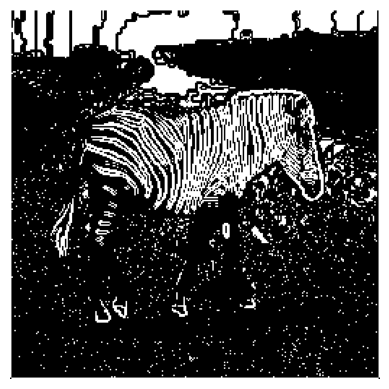

In [65]:
bin_edge_zebra_img = (grad_magnitude_zebra > otsu_zebra_img).astype(float)
plt.imshow(bin_edge_zebra_img, cmap = 'binary')
plt.axis("off")

Text(0.5, 1.0, 'Gaussian Filtered')

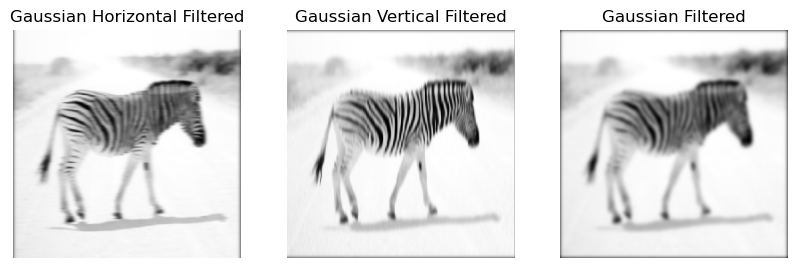

In [66]:
laplacian_fil = np.array([[0, -1, 0],
                          [-1, 4, -1],
                          [0, -1, 0]])

sigma_z = 2.0
filter_size = int(6 * sigma + 1)

Gx_z = gaussian_filter(sigma_z, filter_size)
Gy_z = Gx_z.reshape(-1, 1)

filt_hor_gau_zebra = convolution(Gx_z[np.newaxis, :], zebra)
filt_ver_gau_zebra = convolution(Gy_z, zebra)
filtered_zebra_img = convolution(Gy_z, filt_hor_gau_zebra)

fig = plt.figure(figsize= (10,7))
fig.add_subplot(1,3,1)
plt.imshow(filt_hor_gau_zebra, cmap = 'gray')
plt.axis("off")
plt.title("Gaussian Horizontal Filtered")

fig.add_subplot(1,3,2)
plt.imshow(filt_ver_gau_zebra, cmap = 'gray')
plt.axis("off")
plt.title("Gaussian Vertical Filtered")

fig.add_subplot(1,3,3)
plt.imshow(filtered_zebra_img, cmap = 'gray')
plt.axis("off")
plt.title("Gaussian Filtered")


(-0.5, 255.5, 255.5, -0.5)

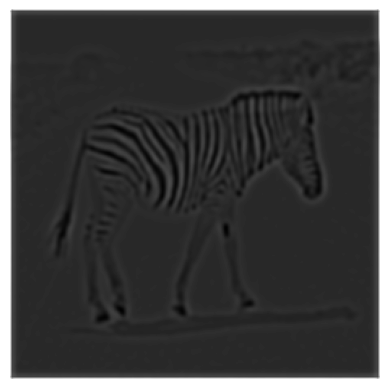

In [67]:
lap_zebra_img = convolution(laplacian_fil, filtered_zebra_img)
plt.imshow(lap_zebra_img, cmap='gray')
plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

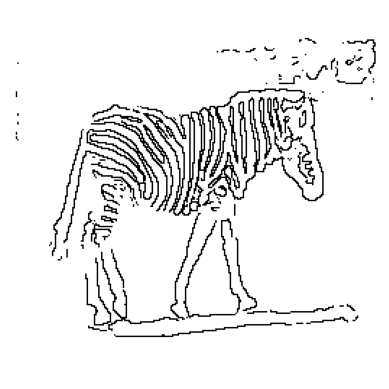

In [71]:
res_zebra_img = detect_zero_crossings(lap_zebra_img, 2)
plt.imshow(res_zebra_img, cmap= 'binary')
plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

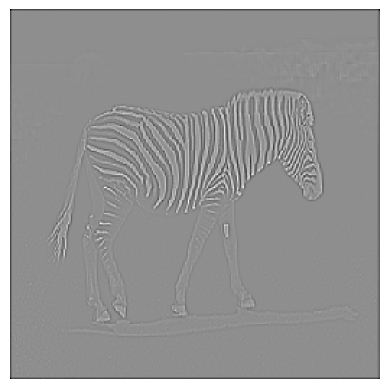

In [72]:
res_zebra_img_2D_fil = convolution(laplacian_fil, zebra)
plt.imshow(res_zebra_img_2D_fil, cmap = 'binary')
plt.axis("off")

## Qn 2

In [73]:
def image_adjust(img):
    img_min = np.min(img)
    img_max = np.max(img)
    adjusted_img = 255 * (img - img_min) / (img_max - img_min)
    return adjusted_img.astype(np.uint8)

In [74]:
def match_template(original_img, template_img):
    # Get dimensions of original and template images
    original_height, original_width = original_img.shape
    template_height, template_width = template_img.shape
    
    # Compute mean of template image
    template_mean = np.mean(template_img)

    # Compute squared sum of template image
    template_squared_sum = np.sum((template_img - template_mean) ** 2)

    # Initialize correlation image
    correlation_img = np.zeros((original_height - template_height + 1, original_width - template_width + 1))

    # Iterate through each position in the original image where the template can fit
    for y in range(original_height - template_height + 1):
        for x in range(original_width - template_width + 1):
            # Extract the region of interest (ROI) from the original image
            roi = original_img[y:y + template_height, x:x + template_width]
            
            # Compute mean of ROI
            roi_mean = np.mean(roi)

            # Compute correlation between ROI and template
            correlation = np.sum((roi - roi_mean) * (template_img - template_mean))

            # Compute squared sum of ROI
            roi_squared_sum = np.sum((roi - roi_mean) ** 2)

            # Normalize the correlation value
            correlation /= np.sqrt(roi_squared_sum * template_squared_sum)

            # Store the correlation value in the correlation image
            correlation_img[y, x] = correlation

    return correlation_img


In [75]:
def plot_image(img, map, title):
    plt.imshow(img, cmap = map)
    plt.axis("off")
    plt.title(title)

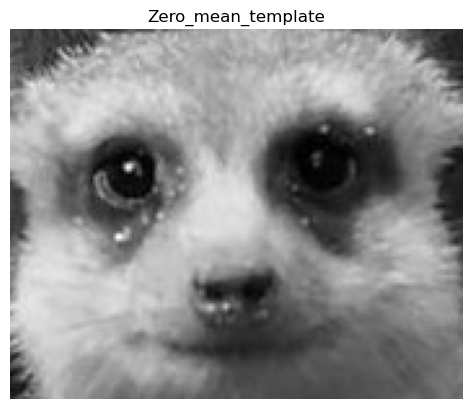

In [76]:
original_img = cv2.imread(r'C:\Users\rhuth\Desktop\SEMS\Sem - 2\CS - GY6643 - Computer Vision\Proj\Proj - 2\animal-family-25.jpg', cv2.IMREAD_GRAYSCALE)
template_img = cv2.imread(r'C:\Users\rhuth\Desktop\SEMS\Sem - 2\CS - GY6643 - Computer Vision\Proj\Proj - 2\animal-family-25-template.jpg', cv2.IMREAD_GRAYSCALE)

    # Convert images to float32
original_img = original_img.astype(np.float32)
template_img = template_img.astype(np.float32)

    # Calculate mean value of the template image
mean_val = np.mean(template_img)

    # Normalize the template image by subtracting the mean
zero_mean_template = template_img - mean_val

    # Explicitly set the mean of the resulting template to 0.0
zero_mean_template -= np.mean(zero_mean_template)

plot_image(zero_mean_template, 'gray', 'Zero_mean_template')

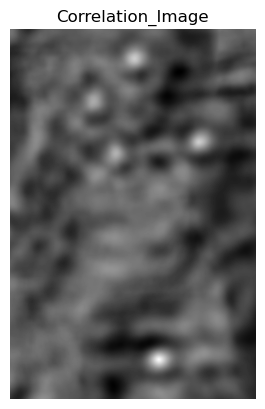

In [77]:
# correlation_img = cv2.matchTemplate(original_img, zero_mean_template, cv2.TM_CCOEFF_NORMED)
correlation_img = match_template(original_img, zero_mean_template)

    # Apply ImageAdjust
correlation_img = image_adjust(correlation_img)
plot_image(correlation_img, 'gray', 'Correlation_Image')


#### with threshold of 60%

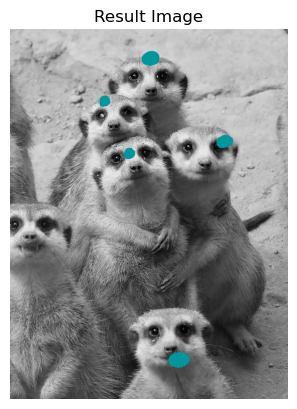

In [78]:
threshold = 0.6 * 255
_, peaks = cv2.threshold(correlation_img, threshold, 255, cv2.THRESH_BINARY)

    # Ensure peaks has the same shape as the original image
peaks = cv2.resize(peaks, (original_img.shape[1], original_img.shape[0]))

    # Overlay the peaks onto the original image
overlay = cv2.cvtColor(original_img.astype(np.uint8), cv2.COLOR_GRAY2BGR)
overlay[peaks > 0] = [1, 150, 155]
plot_image(overlay, 'gray', 'Result Image')



#### with threshold of 80%

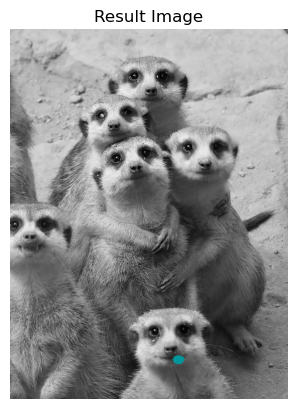

In [79]:
threshold = 0.8 * 255
_, peaks = cv2.threshold(correlation_img, threshold, 255, cv2.THRESH_BINARY)

    # Ensure peaks has the same shape as the original image
peaks = cv2.resize(peaks, (original_img.shape[1], original_img.shape[0]))

    # Overlay the peaks onto the original image
overlay = cv2.cvtColor(original_img.astype(np.uint8), cv2.COLOR_GRAY2BGR)
overlay[peaks > 0] = [1, 150, 155]
plot_image(overlay, 'gray', 'Result Image')


#### with threshold of 100%

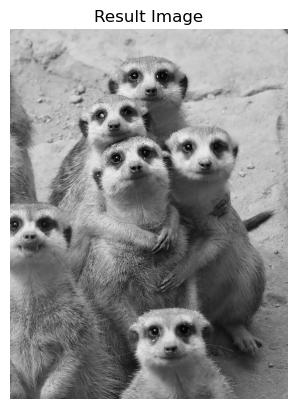

In [80]:
threshold = 1 * 255
_, peaks = cv2.threshold(correlation_img, threshold, 255, cv2.THRESH_BINARY)

    # Ensure peaks has the same shape as the original image
peaks = cv2.resize(peaks, (original_img.shape[1], original_img.shape[0]))

    # Overlay the peaks onto the original image
overlay = cv2.cvtColor(original_img.astype(np.uint8), cv2.COLOR_GRAY2BGR)
overlay[peaks > 0] = [1, 150, 155]
plot_image(overlay, 'gray', 'Result Image')

# Qn 3

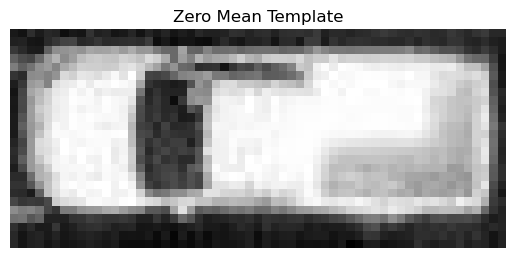

In [81]:
original_img = cv2.imread(r'C:\Users\rhuth\Desktop\SEMS\Sem - 2\CS - GY6643 - Computer Vision\Proj\Proj - 2\car_full_image.jpg', cv2.IMREAD_GRAYSCALE)
template_img = cv2.imread(r'C:\Users\rhuth\Desktop\SEMS\Sem - 2\CS - GY6643 - Computer Vision\Proj\Proj - 2\car_full_image_template.jpg', cv2.IMREAD_GRAYSCALE)

    # Convert images to float32
original_img = original_img.astype(np.float32)
template_img = template_img.astype(np.float32)
original_img_2 = original_img.astype(np.float32)


    # Calculate mean value of the template image
mean_val = np.mean(template_img)

    # Normalize the template image by subtracting the mean
zero_mean_template = template_img - mean_val

    # Explicitly set the mean of the resulting template to 0.0
zero_mean_template -= np.mean(zero_mean_template)

    #show_image('res 1',zero_mean_template)
plot_image(zero_mean_template, 'gray', 'Zero Mean Template')

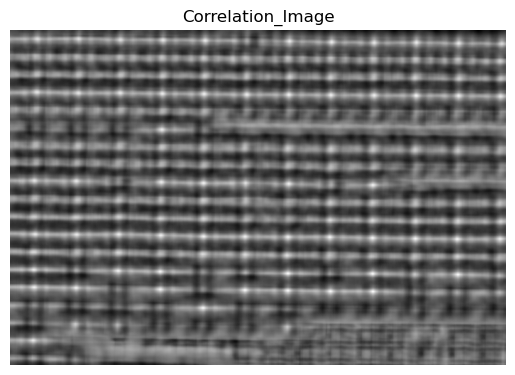

In [82]:
correlation_img = match_template(original_img, zero_mean_template)

    # Apply ImageAdjust
correlation_img = image_adjust(correlation_img)
plot_image(correlation_img, 'gray', 'Correlation_Image')

Number of Cars is: 44


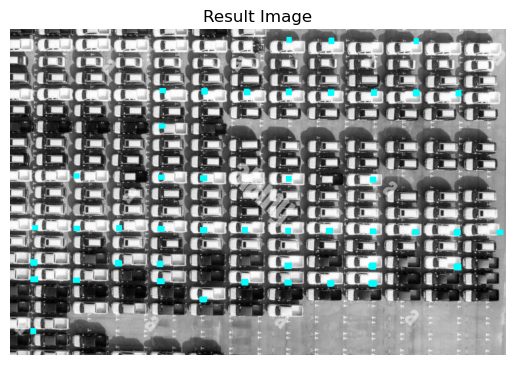

In [83]:
threshold = 0.9 * 255
_, peaks = cv2.threshold(correlation_img, threshold, 255, cv2.THRESH_BINARY)

peaks = cv2.dilate(peaks, None, iterations=3)

    # Find contours of peaks
contours, _ = cv2.findContours(peaks, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Ensure peaks has the same shape as the original image
peaks = cv2.resize(peaks, (original_img.shape[1], original_img.shape[0]))
    # Overlay the peaks onto the original image
overlay = cv2.cvtColor(original_img.astype(np.uint8), cv2.COLOR_GRAY2BGR)
overlay[peaks > 0] = [0, 255, 255]
plot_image(overlay, 'gray', "Result Image")

print('Number of Cars is: '+str(len(contours)))